In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats


In [4]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [5]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

### Task 1 - Problem Analysis and Data Preprocess

In [6]:
base_path = r'.'
files = ['accessories.csv', 'bags.csv', 'beauty.csv', 'house.csv',
         'jewelry.csv', 'kids.csv', 'men.csv', 'shoes.csv', 'women.csv']

data_frames = {file.split('.')[0]: pd.read_csv(os.path.join(base_path, file)) for file in files}

In [7]:
df = pd.concat(data_frames.values(), ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74999 entries, 0 to 74998
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   category               74999 non-null  object 
 1   subcategory            74999 non-null  object 
 2   name                   74999 non-null  object 
 3   current_price          74999 non-null  float64
 4   raw_price              74999 non-null  float64
 5   currency               74999 non-null  object 
 6   discount               74999 non-null  int64  
 7   likes_count            74999 non-null  int64  
 8   is_new                 74999 non-null  bool   
 9   brand                  14161 non-null  object 
 10  brand_url              10340 non-null  object 
 11  codCountry             65889 non-null  object 
 12  variation_0_color      63215 non-null  object 
 13  variation_1_color      52652 non-null  object 
 14  variation_0_thumbnail  63215 non-null  object 
 15  va

####  Pre-process Dataframe

In [8]:
chosen_columns = {'category', 'name', 'current_price', 'raw_price', 'likes_count', 'discount', 'is_new'}
df = df.loc[:, df.columns.intersection(chosen_columns)]

In [9]:
# Define a dictionary with the columns as keys and their fill values as values
fill_values = {
    'likes_count': 0,
    'discount': 0,
    'current_price': df['current_price'].median()
}

# Use a loop to fill missing values for each specified column without using inplace
for column, value in fill_values.items():
    df[column] = df[column].fillna(value)

In [10]:
df = df[df['likes_count'] > 50]

#### Hypothesis 1: Price and Likes Count

**Question**: Is there a significant correlation between the `current_price` and the `likes_count` of products?

- **Null Hypothesis (H0)**: There is no significant correlation between `current_price` and `likes_count`. (Correlation coefficient = 0)
- **Alternative Hypothesis (HA or H1)**: There is a significant correlation between `current_price` and `likes_count`. (Correlation coefficient ≠ 0)

In [11]:
# Calculate Pearson correlation coefficient
correlation = df['current_price'].corr(df['likes_count'])
print("Pearson Correlation Coefficient:", correlation)

Pearson Correlation Coefficient: 0.03592696432826539


In [12]:
import scipy.stats as stats

# Perform Pearson correlation test
correlation, p_value = stats.pearsonr(df['current_price'], df['likes_count'])
print("Pearson Correlation Coefficient:", correlation)
print("P-value:", p_value)


alpha = 0.05

# Decision based on p-value
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant correlation between current_price and likes_count.")
else:
    print("Fail to reject the null hypothesis: There is no significant correlation between current_price and likes_count.")

Pearson Correlation Coefficient: 0.03592696432826539
P-value: 2.5645275053554323e-14
Reject the null hypothesis: There is a significant correlation between current_price and likes_count.


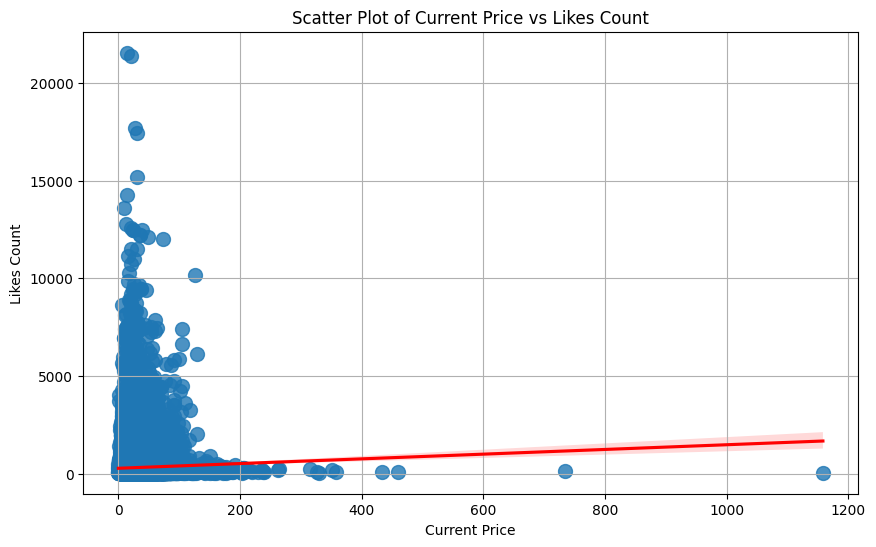

In [13]:
# Plotting with Seaborn
plt.figure(figsize=(10, 6))

# Scatter plot with regression line
sns.regplot(x='current_price', y='likes_count', data=df, scatter_kws={'s':100}, line_kws={'color':'red'})
plt.title('Scatter Plot of Current Price vs Likes Count')
plt.xlabel('Current Price')
plt.ylabel('Likes Count')
plt.grid(True)
plt.show()

#### Hypothesis 2: Discount and Likes Count

**Question**: Does the `discount` offered on a product affect the `likes_count`?

- **Null Hypothesis (H0)**: There is no significant correlation between `discount` and `likes_count`. (Correlation coefficient = 0)
- **Alternative Hypothesis (HA or H1)**: There is a significant correlation between `discount` and `likes_count`. (Correlation coefficient ≠ 0)

Pearson Correlation Coefficient: 0.009173761870393718
Pearson Correlation Coefficient: 0.009173761870393714
P-value: 0.05180133346766552
Fail to reject the null hypothesis: There is no significant correlation between discount and likes_count.


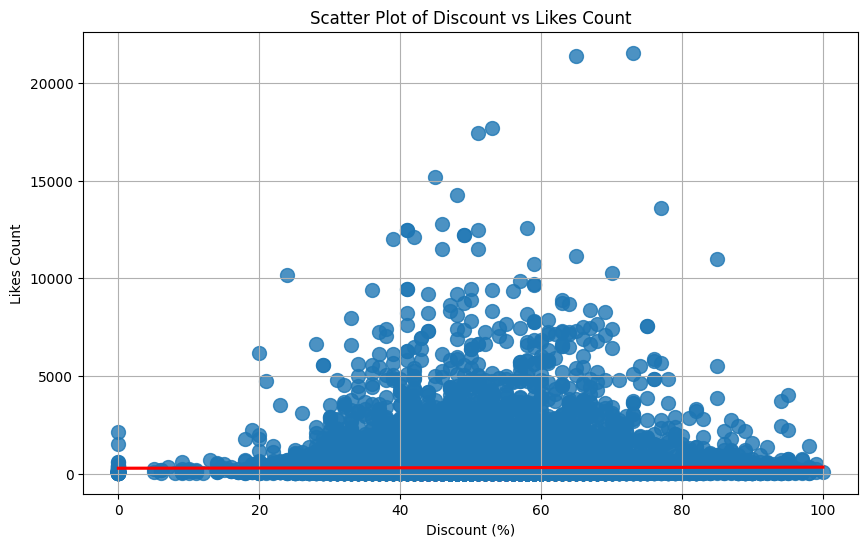

In [14]:
correlation = df['discount'].corr(df['likes_count'])
print("Pearson Correlation Coefficient:", correlation)

import scipy.stats as stats

# Perform Pearson correlation test
correlation, p_value = stats.pearsonr(df['discount'], df['likes_count'])
print("Pearson Correlation Coefficient:", correlation)
print("P-value:", p_value)

# Set the significance level
alpha = 0.05

# Decision based on p-value
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant correlation between discount and likes_count.")
else:
    print("Fail to reject the null hypothesis: There is no significant correlation between discount and likes_count.")

plt.figure(figsize=(10, 6))

# Scatter plot with regression line
sns.regplot(x='discount', y='likes_count', data=df, scatter_kws={'s':100}, line_kws={'color':'red'})
plt.title('Scatter Plot of Discount vs Likes Count')
plt.xlabel('Discount (%)')
plt.ylabel('Likes Count')
plt.grid(True)
plt.show()


#### Hypothesis 3: Comparison of Likes Count Across Categories

**Question**: Is the average `likes_count` different across product categories?

- **Null Hypothesis (H0)**: The average `likes_count` is the same across all product categories.
- **Alternative Hypothesis (HA or H1)**: The average `likes_count` differs across at least one product category.

ANOVA F-statistic: 82.55020726675238
P-value: 2.5262184591460195e-136
Reject the null hypothesis: The average likes_count differs across at least one product category.


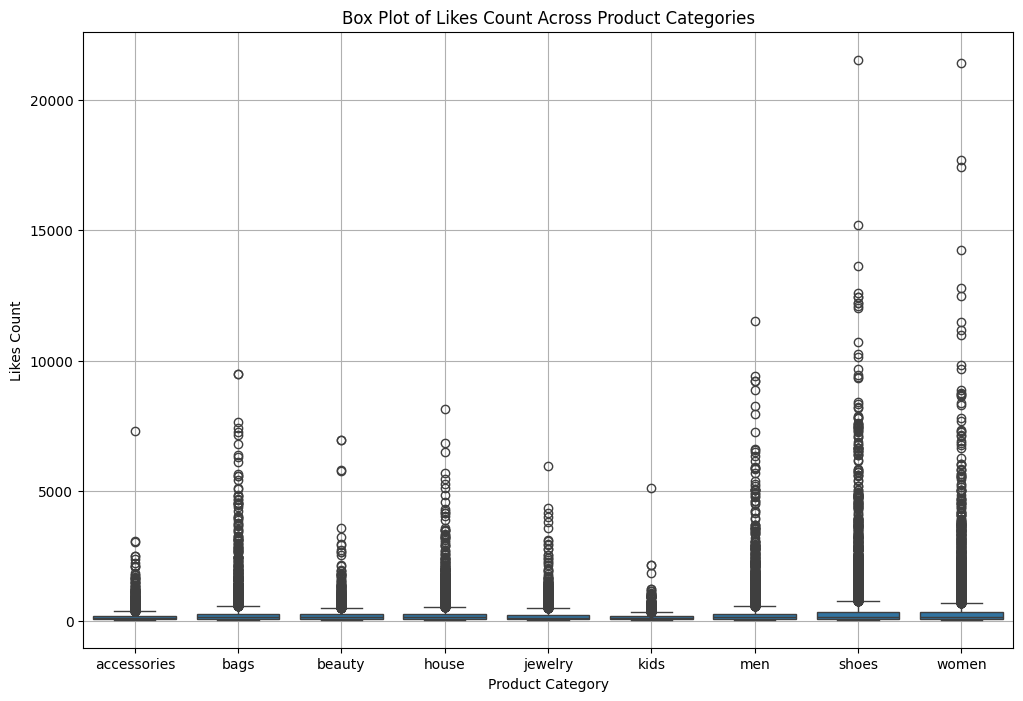

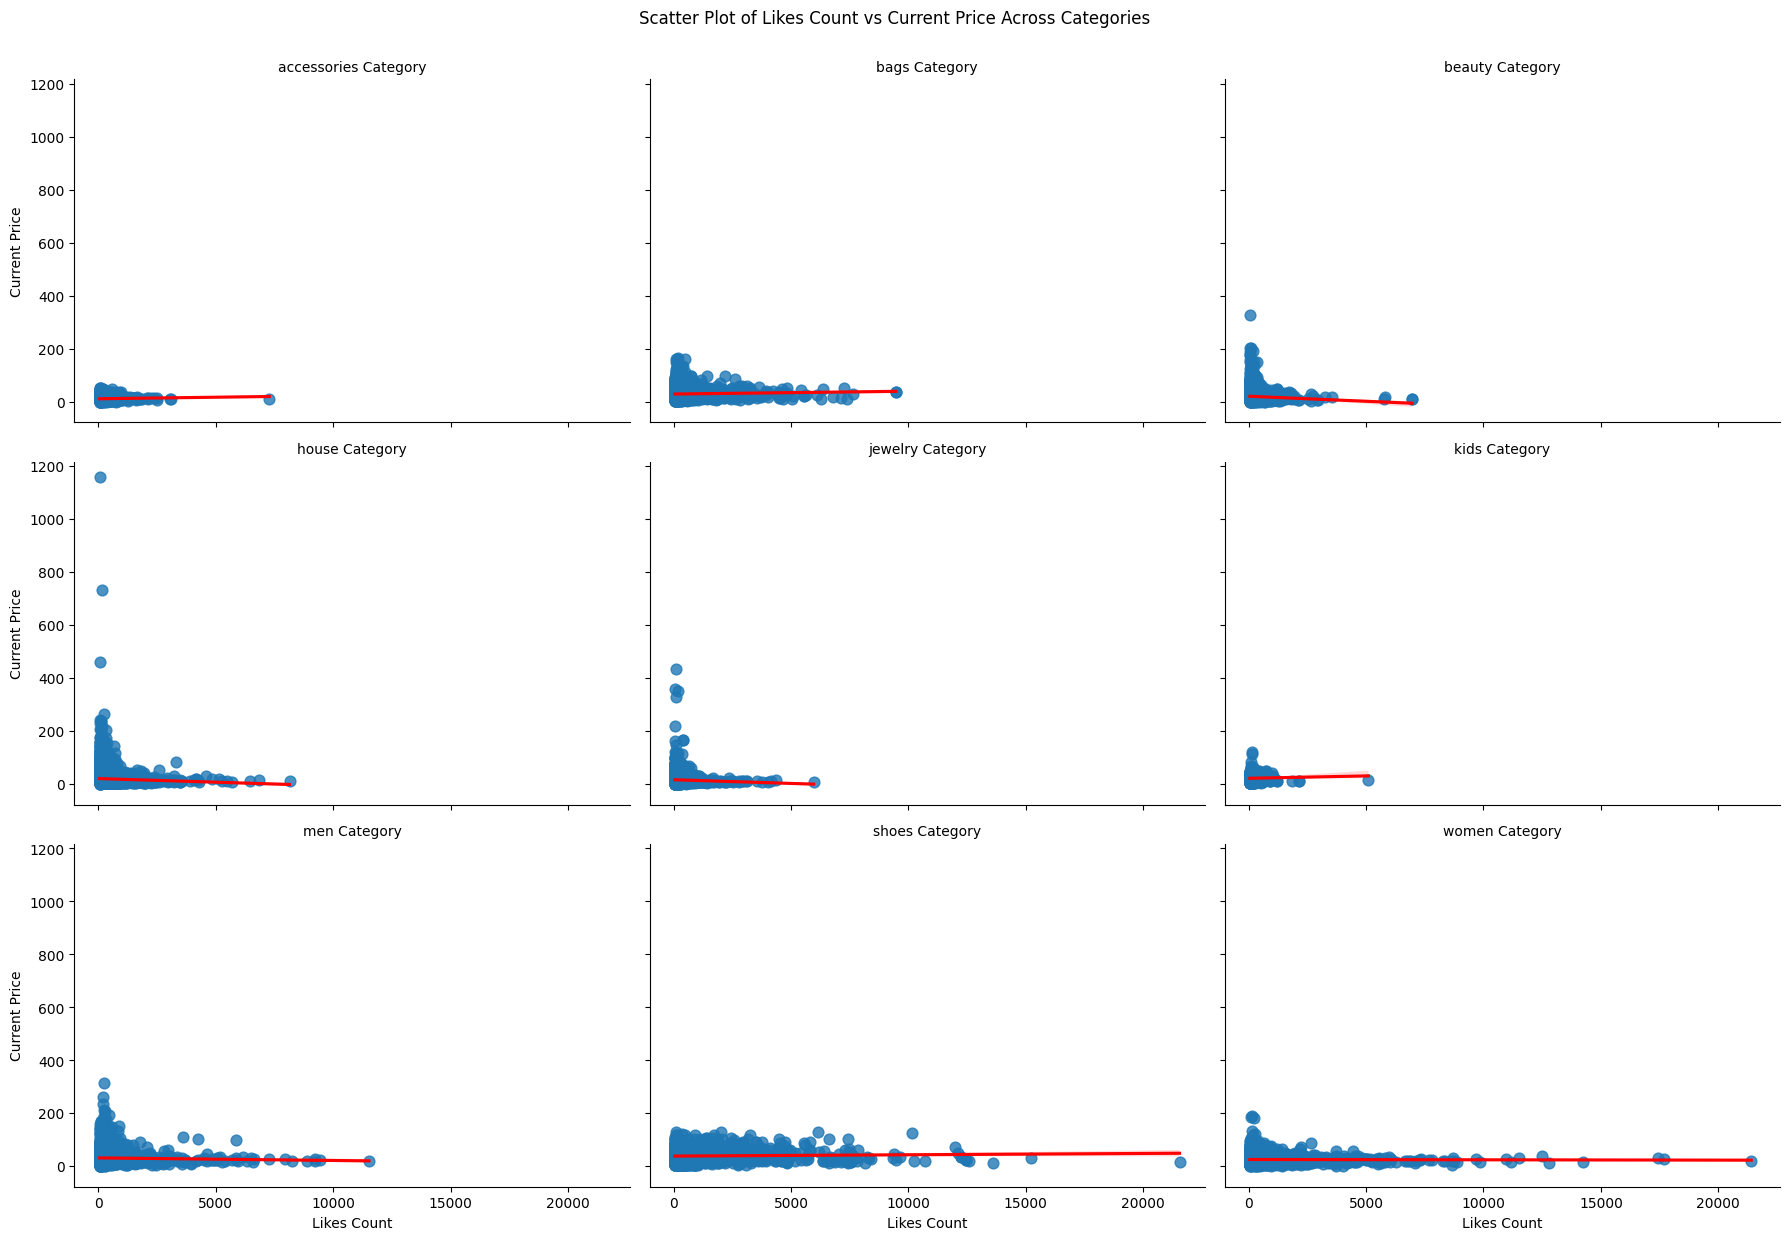

In [15]:
import scipy.stats as stats
import pandas as pd

likes_count_by_category = [group['likes_count'].values for name, group in df.groupby('category')]

f_statistic, p_value = stats.f_oneway(*likes_count_by_category)

print("ANOVA F-statistic:", f_statistic)
print("P-value:", p_value)

# Set the significance level
alpha = 0.05

# Decision based on p-value
if p_value < alpha:
    print("Reject the null hypothesis: The average likes_count differs across at least one product category.")
else:
    print("Fail to reject the null hypothesis: The average likes_count is the same across all product categories.")


plt.figure(figsize=(12, 8))

# Box plot to compare likes count across categories
sns.boxplot(x='category', y='likes_count', data=df)
plt.title('Box Plot of Likes Count Across Product Categories')
plt.xlabel('Product Category')
plt.ylabel('Likes Count')
plt.grid(True)
plt.show()



# Scatter plot with regression line for each category
g = sns.FacetGrid(df, col="category", col_wrap=3, height=4, aspect=1.5)
g.map(sns.regplot, "likes_count", "current_price", scatter_kws={'s':60}, line_kws={'color':'red'})
g.set_axis_labels("Likes Count", "Current Price")
g.set_titles(col_template="{col_name} Category")
g.fig.suptitle("Scatter Plot of Likes Count vs Current Price Across Categories", y=1.03)
plt.show()




#### Hypothesis 4: Price Influence on Discount

**Question**: Does the `raw_price` of a product influence the `discount` applied?

- **Null Hypothesis (H0)**: There is no significant correlation between `raw_price` and `discount`. (Correlation coefficient = 0)
- **Alternative Hypothesis (HA or H1)**: There is a significant correlation between `raw_price` and `discount`. (Correlation coefficient ≠ 0)

Pearson Correlation Coefficient: 0.10686682676239935
Pearson Correlation Coefficient: 0.10686682676239935
P-value: 2.860361249675403e-114
Reject the null hypothesis: There is a significant correlation between raw_price and discount.


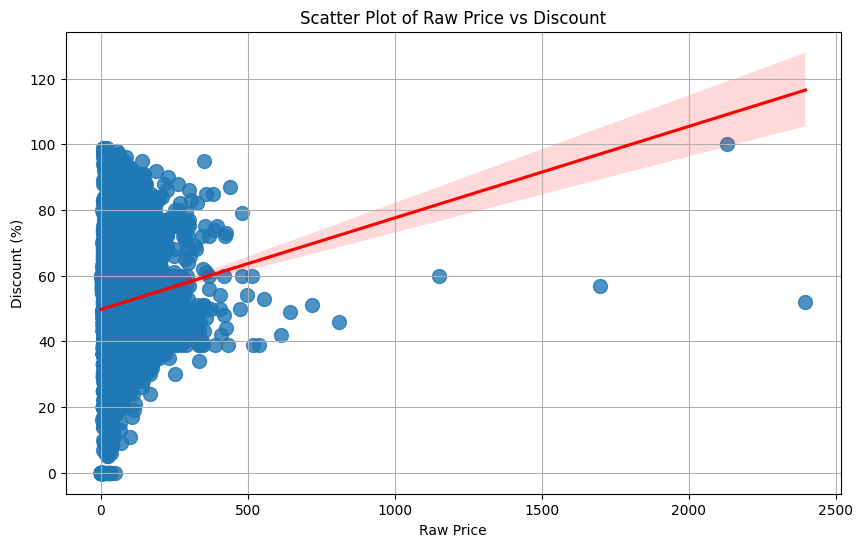

In [16]:
correlation = df['raw_price'].corr(df['discount'])
print("Pearson Correlation Coefficient:", correlation)

import scipy.stats as stats

# Perform Pearson correlation test
correlation, p_value = stats.pearsonr(df['raw_price'], df['discount'])
print("Pearson Correlation Coefficient:", correlation)
print("P-value:", p_value)

# Set the significance level
alpha = 0.05

# Decision based on p-value
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant correlation between raw_price and discount.")
else:
    print("Fail to reject the null hypothesis: There is no significant correlation between raw_price and discount.")


plt.figure(figsize=(10, 6))

# Scatter plot with regression line
sns.regplot(x='raw_price', y='discount', data=df, scatter_kws={'s':100}, line_kws={'color':'red'})
plt.title('Scatter Plot of Raw Price vs Discount')
plt.xlabel('Raw Price')
plt.ylabel('Discount (%)')
plt.grid(True)
plt.show()


#### Premium Categories and Best 7 Categories


In [17]:

# Calculate average price per category and sort in descending order
def get_top_categories_by_price(df, top_n=7):
    avg_price_per_category = df.groupby('category')['current_price'].mean().sort_values(ascending=False)
    top_categories = avg_price_per_category.head(top_n).index.tolist()
    return top_categories

# Filter dataset to include only the top categories
def filter_top_categories(df, top_categories):
    return df[df['category'].isin(top_categories)]

# Find the top N products based on multiple criteria
def get_top_products(df, top_n=10):
    return df.sort_values(
        by=['likes_count', 'current_price', 'discount', 'is_new'],
        ascending=[False, False, False, False]
    ).head(top_n)


# Get top 7 categories based on average current price
top_categories = get_top_categories_by_price(df, top_n=7)

# Filter the dataset to include only products from the top 7 categories
filtered_df = filter_top_categories(df, top_categories)

# Find the top 10 products in these categories
top_products = get_top_products(filtered_df, top_n=10)

# Output results
print("Top 7 Categories (based on average price):", top_categories)

Top 7 Categories (based on average price): ['shoes', 'men', 'bags', 'women', 'kids', 'beauty', 'house']


In [18]:
print("Top 10 Products in the Top 7 Categories:\n", top_products)

Top 10 Products in the Top 7 Categories:
       category                                               name  \
55676    shoes  Chaussures Plats Décontractées En Suède Mocass...   
70482    women               Blouse Large Couleur Pure pour Femme   
70457    women                   Robe Longue avec Boutons Chinois   
63939    women  Gracila Femme Maxi Robe Irrégulier Vêtement Vi...   
56378    shoes  Chaussures De Grande Taille Semelle Souple À E...   
60200    women  Soutien-gorge Sexy à Décollecté Plongeant sans...   
50188    shoes               Bottines Plates Doublées de Fourrure   
63442    women  Soutien-gorge Sexy Antichoc Sans Armature Ling...   
54981    shoes  SOCOFY Sandales Confortables Plates Avec Bride...   
74381    women        Manteau imprimé floral à feuilles à capuche   

       current_price  raw_price  discount  likes_count  is_new  
55676          14.99      54.95        73        21547   False  
70482          19.99      56.99        65        21403   False  
704

### Task 2: Clustering

In [19]:
# Drop non required column
df_cluster = df.drop(['name', 'is_new', 'discount', 'raw_price'], axis=1)

In [20]:
# Applying standard Scaler

# Columns to scale
columns_to_scale = ['current_price', 'likes_count']

# Separate features
features_to_scale = df_cluster[columns_to_scale]
non_features = df_cluster.drop(columns=columns_to_scale)

# Initialize and fit StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_to_scale)

# Convert scaled features back to DataFrame
scaled_features_df = pd.DataFrame(scaled_features, columns=columns_to_scale, index=df_cluster.index)

# Combine scaled features with unchanged columns
df_cluster = pd.concat([non_features, scaled_features_df], axis=1)

In [21]:
# Encoding Label

le_category = LabelEncoder()
df_cluster['category'] = le_category.fit_transform(df_cluster['category'])

In [22]:
# Removing Outliers

# Assuming df_integers is your standardized DataFrame
z_scores = np.abs(stats.zscore(df_cluster))
# Set a threshold for Z-score
threshold = 3
# Boolean mask for inliers
inliers = (z_scores < threshold).all(axis=1)
# Filter the DataFrame
df_cluster = df_cluster[inliers]

In [23]:
X = df_cluster[['current_price', 'likes_count']]
y = df_cluster.drop(columns=['current_price', 'likes_count'])
categories = le_category.inverse_transform(y.to_numpy().ravel())

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Text(0, 0.5, 'WSS')

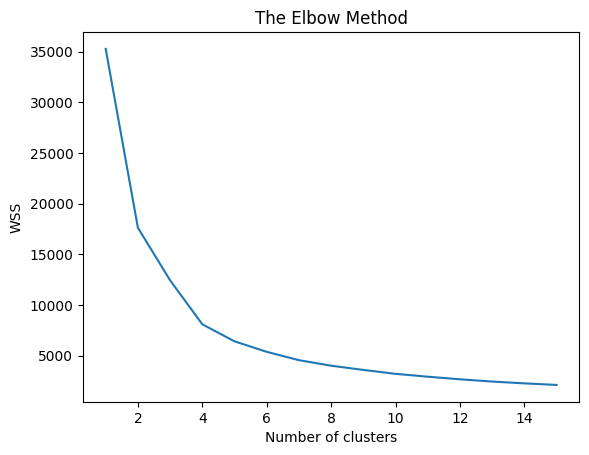

In [24]:
wss = []

for i in range(1, 16):
    kmeans = KMeans(n_clusters=i, init = 'k-means++', random_state=42)
    kmeans.fit(X)
    wss.append(kmeans.inertia_)

plt.plot(range(1, 16), wss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WSS')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


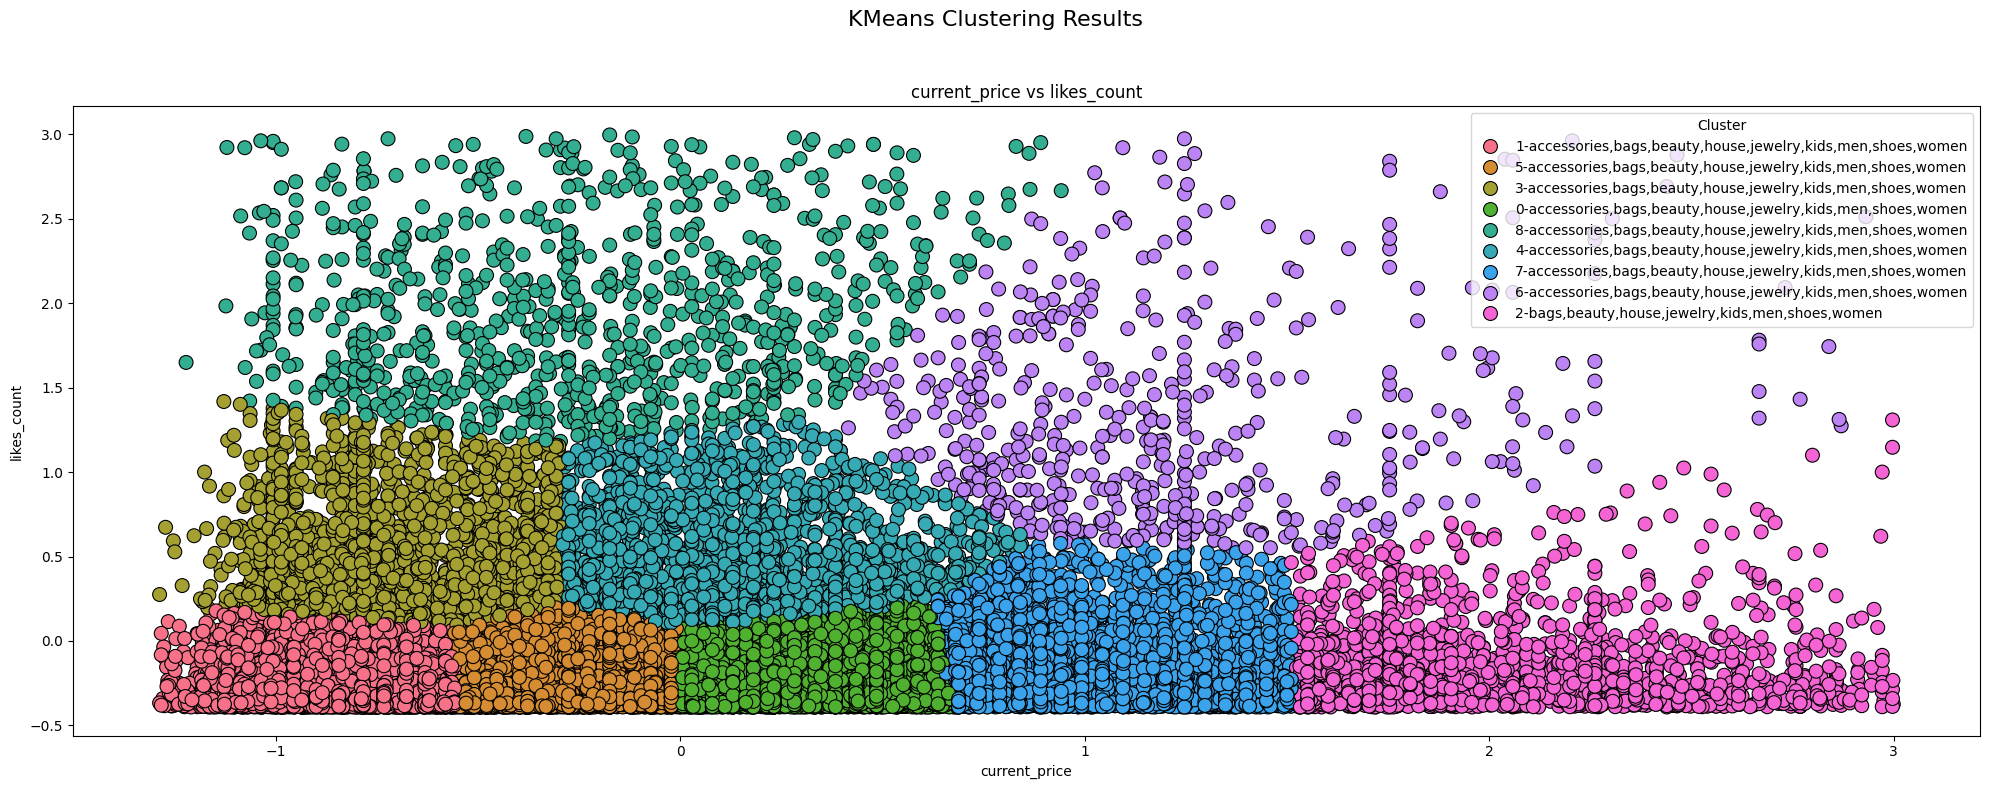

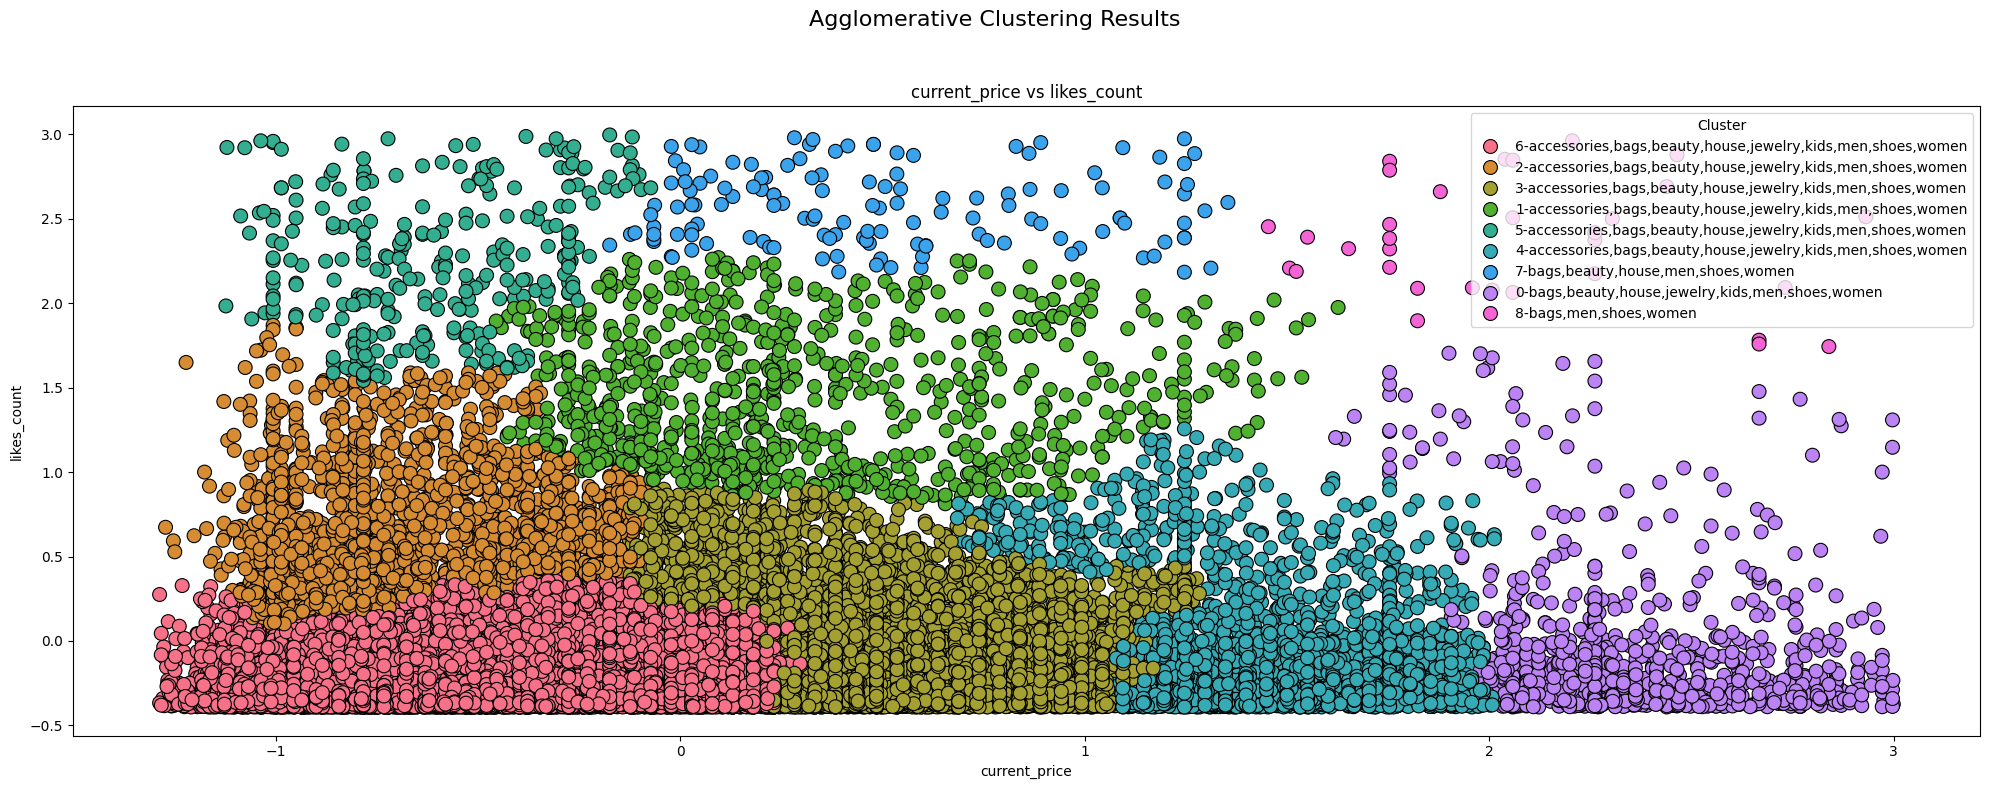


Silhouette Score:
KMeans: 0.4281
Agglomerative: 0.3829

Calinski-Harabasz Index:
KMeans: 48062.9940
Agglomerative: 20383.9248

Davies-Bouldin Index:
KMeans: 0.7600
Agglomerative: 0.8066

Best Algorithm based on Silhouette Score: KMeans


In [25]:
# Dictionary of clustering algorithms
algorithms = {
    "KMeans": KMeans(n_clusters=9, max_iter=1000),
    "Agglomerative": AgglomerativeClustering(n_clusters=9, linkage='complete')
}

# Initialize dictionary to store metrics
metrics = {
    "Silhouette Score": {},
    "Calinski-Harabasz Index": {},
    "Davies-Bouldin Index": {}
}

# Iterate through each algorithm and compute the clustering metrics
for name, algorithm in algorithms.items():
    labels = algorithm.fit_predict(X)

    # Map cluster labels to categories for better readability
    class_dict = pd.DataFrame({'category': categories, 'class': labels})\
                    .groupby('class')['category']\
                    .apply(lambda x: ",".join(sorted(set(x))))\
                    .to_dict()


    # Create combined labels for better understanding of clusters
    combined_labels = [f"{i}-{class_dict.get(i, '')}" for i in labels]

    # Store the calculated metrics
    metrics["Silhouette Score"][name] = silhouette_score(X, labels)
    metrics["Calinski-Harabasz Index"][name] = calinski_harabasz_score(X, labels)
    metrics["Davies-Bouldin Index"][name] = davies_bouldin_score(X, labels)

    # Create a copy of the data with the new labels
    df_copy = X.copy()
    df_copy['label'] = combined_labels

    # Compute mean values for each cluster
    df_mean = df_copy.groupby('label').agg('mean')

    # Visualization
    fig, ax = plt.subplots(figsize=(20, 8))
    columns = list(df_mean.columns)
    palette = sns.color_palette("husl", n_colors=len(df_mean))

    sns.scatterplot(
        x=df_copy[columns[0]],
        y=df_copy[columns[1]],
        hue=combined_labels,
        palette=palette,
        ax=ax,
        s=100,
        edgecolor='k'
    )

    ax.set_title(f'{columns[0]} vs {columns[1]}')
    ax.legend(title='Cluster', loc='upper right')
    ax.set_xlabel(columns[0])
    ax.set_ylabel(columns[1])
    plt.suptitle(f"{name} Clustering Results", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Print the metrics for each algorithm
for metric_name, metric_values in metrics.items():
    print(f"\n{metric_name}:")
    for algo_name, value in metric_values.items():
        print(f"{algo_name}: {value:.4f}")

# Determine the best algorithm based on the Silhouette Score
best_algorithm = max(metrics["Silhouette Score"], key=metrics["Silhouette Score"].get)
print(f"\nBest Algorithm based on Silhouette Score: {best_algorithm}")


### Task 3: Classification

#### Classify if the product will be popular

In [26]:
# set the popularity threshold

df['popularity'] = df['likes_count'].apply(lambda x: 1 if x > df['likes_count'].mean() else 0)

In [27]:
le_category = LabelEncoder()
df['category'] = le_category.fit_transform(df['category'])

In [28]:
df['is_new'] = df['is_new'].astype(int)

In [29]:
# Select features and target

X = df[['category', 'current_price', 'is_new', 'raw_price']]
y = df['popularity']

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 18, 'weights': 'uniform'}
Average Accuracy: 77.19%
Standard Deviation: 0.21%
Accuracy for this fold: 76.93%
Confusion Matrix for this fold:
[[3413   70]
 [ 967   45]]


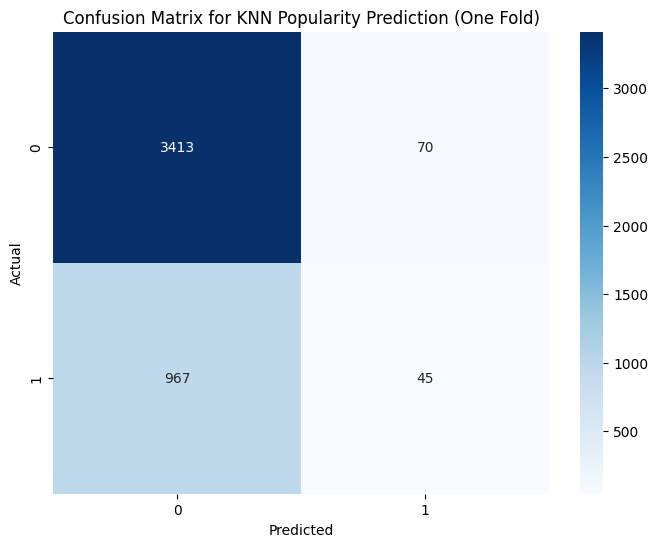

In [47]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

# Set the popularity threshold
df['popularity'] = df['likes_count'].apply(lambda x: 1 if x > df['likes_count'].mean() else 0)

# Label encoding for categorical features
le_category = LabelEncoder()
df['category'] = le_category.fit_transform(df['category'])
df['is_new'] = df['is_new'].astype(int)

# Select features and target
X = df[['category', 'current_price', 'is_new', 'raw_price']]
y = df['popularity']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
knn = KNeighborsClassifier()

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_neighbors': [i for i in range(0,20,2)],
    'weights': ['uniform'],
    'metric': ['manhattan']
}
grid_search = GridSearchCV(knn, param_grid, cv=skf, scoring='accuracy')
grid_search.fit(X_scaled, y)

# Best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Cross-validation with the best estimator
cv_scores = cross_val_score(grid_search.best_estimator_, X_scaled, y, cv=skf, scoring='accuracy')

# Print average accuracy and standard deviation
print(f'Average Accuracy: {cv_scores.mean() * 100:.2f}%')
print(f'Standard Deviation: {cv_scores.std() * 100:.2f}%')

# Evaluate confusion matrix and ROC-AUC for each fold
for train_index, test_index in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit model and make predictions
    model = grid_search.best_estimator_
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f'Accuracy for this fold: {accuracy * 100:.2f}%')
    print('Confusion Matrix for this fold:')
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for KNN Popularity Prediction (One Fold)')
    plt.show()

    break


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
Accuracy: 77.18%
Confusion Matrix:
[[6852  132]
 [1919   86]]


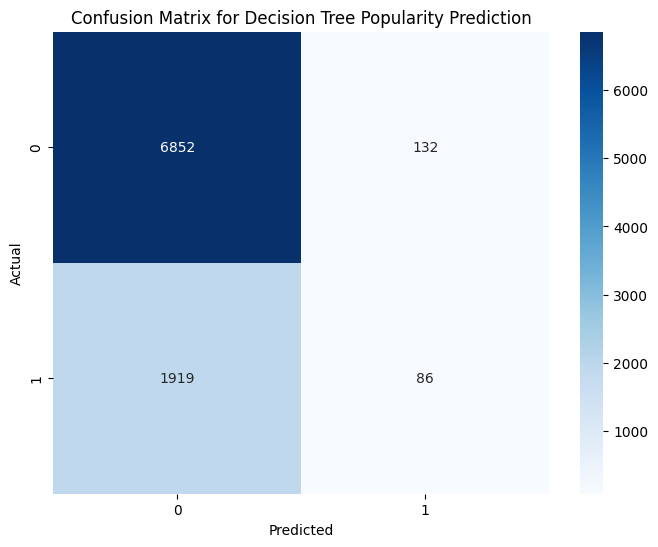

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

# grid serch
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_dt = grid_search.best_estimator_

best_dt.fit(X_train, y_train)

# predictions on the testing data
y_pred = best_dt.predict(X_test)

# evaluate the model
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f'Best Parameters: {best_params}')
print(f'Accuracy: {accuracy * 100:.2f}%')
print('Confusion Matrix:')
print(cm)

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Decision Tree Popularity Prediction')
plt.show()
